## **Instalasi dan Import Library**



In [ ]:
# install library
!pip install newspaper3k nltk pandas lxml_html_clean imbalanced-learn matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import nltk
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from newspaper import Article
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# download resource bahasa
nltk.download('punkt')
nltk.download('punkt_tab')

print("✅ Instalasi dan Import Selesai!")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 10.0 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=513648ddba4654169c8d00bfb18b309124057fd8c4eb730988f7c8fe1d242049
  Stored in directory: /root/.cache/pip/wheels/a5/91/9f/00d66475960891a64867914273fcaf78df6cb04d905b104a2a
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3341 sha256=a73c992464e245106483b429d987959f776bde75e1a25448f96faf9a88248e9c
  Stored in directory: /root/.cache/pip/wheels/9f/9f/fb/364871d7426d3cdd4d293dcf7e53d97f1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Instalasi dan Import Selesai!


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# **Kamus Lexicon Based untuk Labeling**

In [ ]:
# Kamus dan Cleaning

# kamus kata
lexicon_sumut = {
    # skor -5
    'amblas': -5,
    'anaktirikan': -5,
    'biadab': -5,
    'fiktif': -5,
    'hancur': -5,
    'isolir': -5,
    'kupak-kapik': -5,
    'longsor': -5,
    'maut': -5,
    'mangkrak': -5,
    'mark-up': -5,
    'neraka': -5,
    'putus': -5,
    'suap': -5,
    'tewas': -5,

    # skor -4
    'abaikan': -4,
    'amburadul': -4,
    'ancam': -4,
    'asal-asalan': -4,
    'bahaya': -4,
    'biarkan': -4,
    'darurat': -4,
    'kecelakaan': -4,
    'kubangan': -4,
    'memprihatinkan': -4,
    'palsu': -4,
    'parah': -4,
    'tutup mata': -4,
    'terbengkalai': -4,

    # Skor -3
    'becek': -3,
    'berlubang': -3,
    'debu': -3,
    'kecewa': -3,
    'kesal': -3,
    'lubang': -3,
    'lumpur': -3,
    'macet': -3,
    'mengeluh': -3,
    'retak': -3,
    'rusak': -3,
    'tagih': -3,
    'tuntut': -3,
    'terhambat': -3,
    'tipis': -3,
    'mengelupas': -3,
    'lalai': -3,
    'molor': -3,

    # skor -2
    'debu': -2,
    'genangan': -2,
    'gelombang': -2,
    'janji': -2,
    'lambat': -2,
    'lelet': -2,
    'licin': -2,
    'ngadu': -2,
    'sulit': -2,
    'sulam': -2,
    'tambal': -2,
    'terganggu': -2,
    'viralkan': -2,

    # skor -1
    'wacana': -1,

    # skor 1
    'akan': 1,
    'anggaran': 1,
    'rencana': 1,
    'target': 1,
    'tinjau': 1,

    # skor 2
    'evaluasi': 2,
    'kasih': 2,
    'perhatian': 2,
    'prioritas': 2,
    'teguran': 2,
    'terima': 2,

    # skor 3
    'aspal': 3,
    'bangun': 3,
    'benahi': 3,
    'bantu': 3,
    'beton': 3,
    'gerak': 3,
    'instruksi': 3,
    'kerjakan': 3,
    'pembangunan': 3,
    'perbaikan': 3,
    'perbaiki': 3,
    'sidak': 3,
    'dukung': 3,
    'blacklist': 3,

    # skor 4
    'bebas': 4,
    'hotmix': 4,
    'rampung': 4,
    'respon': 4,
    'selesai': 4,

    # skor 5
    'apresiasi': 5,
    'kinclong': 5,
    'mantap': 5,
    'mulus': 5,
    'nyaman': 5,
}

# fungsi cleaning
def clean_text(text):
    text = str(text).lower().replace('\n', ' ')
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# fungsi scoring
def get_sentiment_score(text):
    skor = 0
    kata_kata = text.split()

    # Konteks tetap dipakai
    konteks_keluhan = ['jalan', 'lubang', 'rusak', 'warga', 'pengendara', 'truk', 'macet', 'air', 'banjir', 'lumpur', 'aspal', 'proyek', 'desa', 'kecamatan']

    for i, kata in enumerate(kata_kata):
        if kata in lexicon_sumut:
            nilai = lexicon_sumut[kata]
            if i > 0 and kata_kata[i-1] in ['tidak', 'bukan', 'belum', 'jangan', 'tak', 'gak']:
                nilai *= -1
            skor += nilai

    if skor >= 1:
        return "Positif"
    elif skor <= -1:
        return "Negatif"
    else:
        # Skor 0 (Netral Murni)
        # Kalau bahas jalan tapi skor 0, kemungkinan keluhan implisit -> Negatif
        if any(k in text for k in konteks_keluhan):
            return "Negatif"
        return "Netral"

print("Fungsi Scoring telah selesai!")

Fungsi Scoring telah selesai!


# **Scraping Data, Preprocessing & Auto Labeling**

In [ ]:
import requests
from newspaper import Article, Config
from nltk.tokenize import sent_tokenize
import time
import random
import pandas as pd
import re
import os

# konfigurasi penyamaran
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Referer': 'https://www.google.com/',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1'
}

# daftar link berita
urls_berita = [
    "https://www.detik.com/sumut/berita/d-8031956/viral-warga-protes-dengan-mancing-di-jalan-rusak-pemkab-deli-serdang-sabar",
    "https://www.detik.com/sumut/berita/d-8131179/sudah-rusak-puluhan-tahun-perbaikan-jalan-labura-toba-dikerjakan-tahun-ini",
    "https://sumut.antaranews.com/berita/615605/gubernur-sumut-perbaiki-jalan-rusak-gunungsitoli-nias-utara",
    "https://www.detik.com/sumut/berita/d-8220013/jalan-pelita-vi-medan-banyak-lubang-warga-kesal-kendaraan-jadi-cepat-rusak/amp",
    "https://medan.viva.co.id/medan/9109-ini-lima-jalan-rusak-berat-yang-segera-diperbaiki-pemko-medan",
    "https://www.waspada.id/medan/jalan-sunggal-rusak-parah-seperti-kubangan-kerbau-warga-menangis/",
    "https://daerah.sindonews.com/read/1615231/174/respons-aduan-warga-legislator-partai-perindo-binsar-simarmata-dorong-pemkot-medan-benahi-jalan-dan-bangun-drainase-1756868971/5",
    "https://www.detik.com/sumut/berita/d-7883242/jalan-di-paluta-tapsel-20-tahun-rusak-parah-warga-ngadu-ke-bobby-nasution",
    "https://nasional.tvrinews.com/berita/tdbrjkg-warga-kepulauan-nias-desak-pemprov-sumut-segera-perbaiki-jalan-rusak",
    "https://www.metrotvnews.com/read/koGCd2JA-jalan-rusak-30-tahun-pertumbuhan-ekonomi-dolok-paluta-terhambat",
    "https://www.rubis.id/2025/04/21/kesal-anggota-dprd-minta-pemko-medan-perbaiki-jalan-rusak-akses-pasar-induk-lau-chi",
    "https://www.waspada.id/aceh/rusak-parah-jalan-lintas-nasional-warnai-kabupaten-karo-dairi-dan-pakpak-bharat/",
    "https://www.antaranews.com/berita/5136505/gubernur-sumut-targetkan-ruas-jalan-labura-toba-diperbaiki-tahun-ini",
    "https://www.waspada.id/medan/warga-keluhkan-jalan-rusak-berlobang-di-harjosari-i/",
    "https://www.detik.com/sumut/berita/d-8224501/lapor-pak-wali-ada-lubang-besar-di-jalan-karya-bakti-medan-bahayakan-pengendara",
    "https://sumut.idntimes.com/news/sumatera-utara/15-tahun-rusak-jalan-bahorok-mulai-diperbaiki-2026-00-f4z9n-s10xlc",
    "https://medan.kompas.com/read/2025/11/26/161741378/banjir-dan-longsor-di-tapanuli-selatan-akses-jalan-nasional-putus-dan-lumpuh",
    "https://www.detik.com/sumut/berita/d-8228500/jalan-sidorukun-rusak-camat-medan-timur-sudah-disurati-ke-upt-sdabmbk",
    "https://www.sumatera24jam.com/2025/10/1000-km-jalan-simalungun-rusak-warga.html",
    "https://www.detik.com/sumut/berita/d-8068036/pemprov-sumut-anggarkan-rp-165-miliar-untuk-perbaiki-6-jalan-di-nias",
    "https://web.simalungunkab.go.id/2025/10/24/tinjau-jalan-provinsi-putus-akibat-longsor-bupati-simalungun-perintahkan-kadis-putr-l",
    "https://www.waspada.id/sumut/jalan-provinsi-ruas-gunungsitoli-menuju-nias-barat-terancam-putus/",
    "https://www.sinata.id/jalan-rusak-parah-di-ujung-purba-simalungun-dikeluhkan-warga/",
    "https://www.detik.com/sumut/berita/d-8178422/jalan-rusak-bikin-warga-di-asahan-terpaksa-gotong-jenazah-menuju-rumah-duka",
    "https://agaranews.com/2025/11/25/sinergi-tni-aparat-dan-warga-jalan-rusak-di-barusjahe-ditimbun-bersama/",
    "https://medanbisnisdaily.com/news/online/read/2025/11/19/194940/jalan_penghubung_sergai_tebing_tinggi_rusak_parah_warga_batu_12_",
    "https://www.waspada.id/sumut/jalan-rusak-panyabungan-warga-desak-bupati-madina-bertindak/",
    "https://www.sinata.id/5-tahun-warga-keluhkan-jalan-rusak-dekat-rumah-dinas-wakil-wali-kota-siantar/",
    "https://sumut.suara.com/read/2025/04/25/153613/puluhan-tahun-rusak-bobby-nasution-target-perbaiki-jalan-3-kabupaten-tahun-ini",
    "http://medan.kompas.com/read/2025/11/28/181329878/jalan-tol-medan-kualanamu-tebing-tinggi-amblas-jasa-marga-beri-penjelasan",
    "https://medanbisnisdaily.com/news/online/read/2025/11/28/195218/jalan_menuju_kantor_camat_tanjung_beringin_dan_kantor_bupati_ser",
    "https://www.metro-online.co/2025/11/jalan-di-desa-bandar-klippa-kecamatan-percut-seituan-masih-dilanda-banjir.html",
    "https://www.tempo.co/politik/jalan-di-tapanuli-tengah-rusak-imbas-bencana-distribusi-bantuan-dikirim-via-jalur-udara-2093873",
    "https://www.detik.com/sumut/berita/d-8230486/jalinsum-penghubung-pakkat-dolok-sanggul-humbahas-putus-total-akibat-banjir",
    "http://medan.kompas.com/read/2025/11/27/171209778/jalan-binjai-medan-lumpuh-diterjang-banjir-pengendara-motor-dialihkan-lewat",
    "https://www.taslabnews.com/2025/06/percepat-perbaikan-infrastruktur-wali-kota-tanjungbalai-datangi-dirjen-bina-marga-kementerian",
    "https://deteksi.co/pengaspalan-jalan-desa-pegagan-julu-vii-dairi-rusak-dalam-hitungan-hari/",
    "https://www.cnews.web.id/2025/09/jalan-rusak-sepanjang-2-km-di-dusun-5.html",
    "https://kowarnews.co.id/tahun-2025-plt-bupati-palas-minta-perbaikan-peningkatan-jalinsum-tetap-jadi-perhatian-pemprov-sumut/",
    "https://www.mimbarsumut.com/ragam/jalan-rusak-parah-di-desa-sarahili-nias-selatan-warga-bertaruh-nyawa-demi-aktivitas-sehari-har",
    "https://sumut.antaranews.com/berita/646541/bpbd-sumut-13-korban-meninggal-akibat-bencana-hidrometeorologi",
    "https://sumut.antaranews.com/berita/641681/dinas-putr-samosir-gerak-cepat-tangani-ambles-di-jembatan-siriaon-pendistribusian-mbg",
    "https://sumut.antaranews.com/berita/646541/bpbd-sumut-13-korban-meninggal-akibat-bencana-hidrometeorologi",
    "https://deteksi.co/pembangunan-properti-jewel-garden-di-sampali-dinilai-abaikan-keselamatan-warga-jalan-rusak-dan-kecelakaan-ter",
    "https://www.88news.id/2025/10/acai-sembada-perbaiki-20-titik-jalan.html",
    "https://www.waspada.id/sumut/tebing-runtuh-putuskan-akses-jalan-padangsidimpuan-ke-kota-medan/",
    "https://www.detik.com/sumut/berita/d-8223190/pemkot-medan-soal-jalan-rusak-di-simpang-kantor-segera-diperbaiki",
    "https://infotrafficid.com/jalan-rusak-simpang-kantor-medan-labuhan-nasional/",
    "https://www.rmolsumut.id/jalan-rusak-di-medan-marelan-akhirnya-diperbaiki-pekan-depan-mulai-dikerjakan",
    "https://www.bidikkasusnews.com/2025/08/jalan-secanggangstabat-rusak-juga.html",
    "https://metroekspress.com/11/09/2025/berita-sumut/ekspos-langkat/jalan-rusak-4-km-dari-stabat-secanggang-rugikan-warga-aktivis-desak-pemerintah-segera-bertindak/",
    "https://www.langkatkab.go.id/berita/5462/syah-afandin-tinjau-jalan-rusak-di-stabat-dan-secanggang-pastikan-perbaikan-dimulai-okt",
    "https://www.sinarsumutnews.com/2025/08/proses-lelang-proyek-jalan-provinsi.html",
    "https://www.waspada.id/sumut/jalan-rusak-panyabungan-warga-desak-bupati-madina-bertindak/",
    "https://diskominfo.madina.go.id/jalan-menuju-objek-wisata-di-madina-rusak/",
    "https://diskominfo.madina.go.id/waspada-banyak-titik-jalan-longsor-di-panyabungan-selatan/",
    "https://simantab.com/perbaikan-jalan-viyata-yudha-dilakukan-akhir-tahun-warga-pertanyakan-kualitas-dan-koordinasi-antarinstansi/",
    "https://www.sbnpro.com/alex-damanik-gelar-reses-di-siantar-marihat-warga-keluhkan-drainase-dan-jalan-rusak/",
    "https://analisadaily.com/berita/arsip/2014/9/1/59714/jalan-provinsi-di-batubara-semakin-parah/",
    "https://bataratv.com/belum-setahun-dikerjakan-proyek-jembatan-sidalu-dalu-cinta-damai-indrapura-berlubang-menunggu-korban-kecelakaan/",
    "https://tribratanews.resbatubara.sumut.polri.go.id/kapolsek-indrapura-pimpin-gotong-royong-pasca-banjir-warga-dan-pemerintah-desa-bersatu/",
    "https://www.digtara.com/nusantara/76362/jalan-rusak-dan-berlubang-resahkan-pengendara-di-tebing-tinggi/",
    "https://bongkarnews.com/baru-setahun-peningkatan-ruas-jalan-rambutan-kecamatan-tebing-tinggi-sudah-rusak/",
    "https://medan.kompas.com/read/2025/11/28/164813978/jalan-tol-tebing-tinggi-medan-amblas-lalu-lintas-dialihkan"
]

data_final = []
print(f"gaspol scraping {len(urls_berita)} link berita...")

for url in urls_berita:
    try:
        response = requests.get(url, headers=headers, timeout=20)

        if response.status_code == 200:
            article = Article(url)
            article.download(input_html=response.text)
            article.parse()

            kalimat_list = sent_tokenize(article.text)

            for kalimat in kalimat_list:
                teks_bersih = clean_text(kalimat)
                if len(teks_bersih.split()) < 3: continue

                label = get_sentiment_score(teks_bersih)
                data_final.append({'Sumber': 'Berita', 'Teks': teks_bersih, 'Label': label})

            print(f"[V] Sukses: {url[:35]}... (+{len(kalimat_list)} kalimat)")
        else:
            print(f"[X] Masih diblokir (Status {response.status_code}): {url[:35]}...")

        # jeda acak
        time.sleep(random.uniform(2, 4))

    except Exception as e:
        print(f"[!] Error teknis di {url[:30]}: {str(e)[:50]}")

# save hasil
df = pd.DataFrame(data_final)
df.to_csv("dataset_siap_olah.csv", index=False)
print(f"\nTotal Data Final: {len(df)}")
print(df['Label'].value_counts())

gaspol scraping 64 link berita...
[V] Sukses: https://www.detik.com/sumut/berita/... (+27 kalimat)
[V] Sukses: https://www.detik.com/sumut/berita/... (+13 kalimat)
[V] Sukses: https://sumut.antaranews.com/berita... (+0 kalimat)
[V] Sukses: https://www.detik.com/sumut/berita/... (+20 kalimat)
[V] Sukses: https://medan.viva.co.id/medan/9109... (+17 kalimat)
[V] Sukses: https://www.waspada.id/medan/jalan-... (+30 kalimat)
[V] Sukses: https://daerah.sindonews.com/read/1... (+6 kalimat)
[V] Sukses: https://www.detik.com/sumut/berita/... (+18 kalimat)
[V] Sukses: https://nasional.tvrinews.com/berit... (+19 kalimat)
[V] Sukses: https://www.metrotvnews.com/read/ko... (+14 kalimat)
[V] Sukses: https://www.rubis.id/2025/04/21/kes... (+21 kalimat)
[V] Sukses: https://www.waspada.id/aceh/rusak-p... (+23 kalimat)
[V] Sukses: https://www.antaranews.com/berita/5... (+20 kalimat)
[V] Sukses: https://www.waspada.id/medan/warga-... (+19 kalimat)
[V] Sukses: https://www.detik.com/sumut/berita/... (+15 ka

# **Visualisasi Hasil Scraping Data (Awal)**

Data breakdown:
Label
Negative    541
Neutral     170
Positive    148
Name: count, dtype: int64


/tmp/ipython-input-2422776511.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


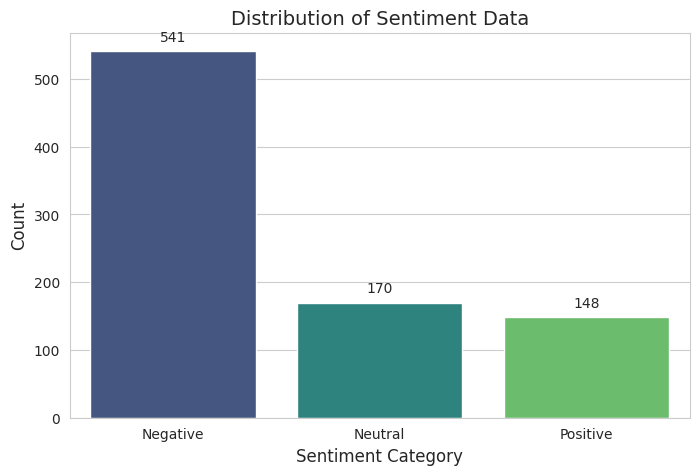

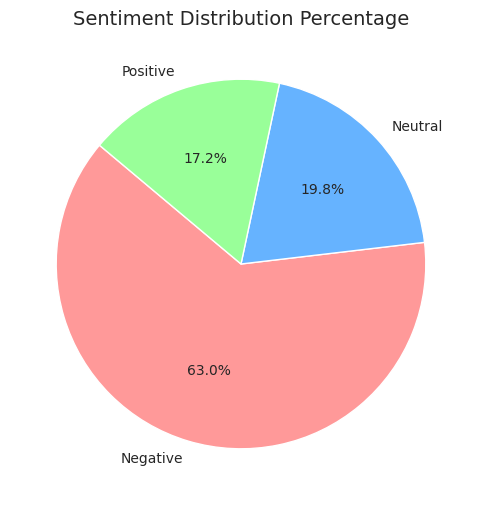

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read file
df_vis = pd.read_csv("dataset_siap_olah.csv")

translation_map = {
    'Negatif': 'Negative',
    'Netral': 'Neutral',
    'Positif': 'Positive'
}
df_vis['Label'] = df_vis['Label'].replace(translation_map)

print("Data breakdown:")
print(df_vis['Label'].value_counts())

sns.set_style("whitegrid")

# grafik bar chart
plt.figure(figsize=(8, 5))

ax = sns.countplot(
    x='Label',
    data=df_vis,
    palette='viridis',
    order=['Negative', 'Neutral', 'Positive']
)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points')

plt.title('Distribution of Sentiment Data', fontsize=14)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# grafik pie chart
plt.figure(figsize=(6, 6))
counts = df_vis['Label'].value_counts()
warna = ['#ff9999', '#66b3ff', '#99ff99']

# plotting
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=warna)

plt.title('Sentiment Distribution Percentage', fontsize=14)
plt.show()

# **Wordcloud**

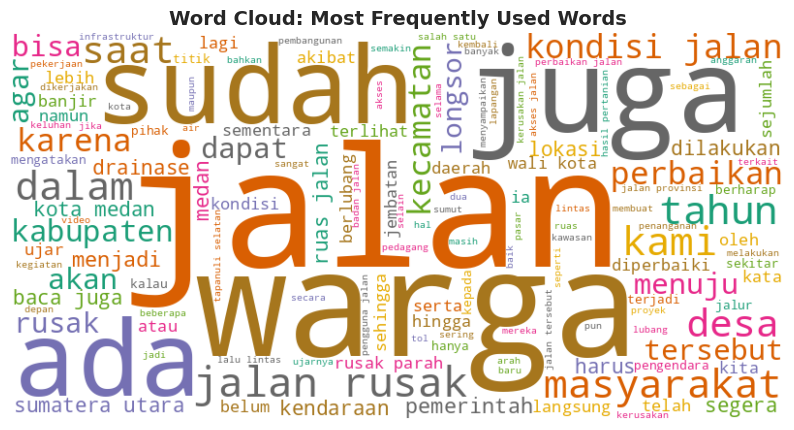

In [ ]:
# install library
!pip install wordcloud

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

all_text = ' '.join(df['Teks'].astype(str).tolist())

stopwords_id = set(['yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'pada', 'adalah', 'dengan', 'saya', 'aku', 'tidak', 'yg', 'kalo', 'nya'])

# buat wordCloud
wc = WordCloud(width=800, height=400,
               background_color='white',
               stopwords=stopwords_id,
               min_font_size=10,
               colormap='Dark2').generate(all_text)

# show
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Most Frequently Used Words', fontsize=14, fontweight='bold')
plt.show()

# **Wordcloud (After Preprocessing)**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


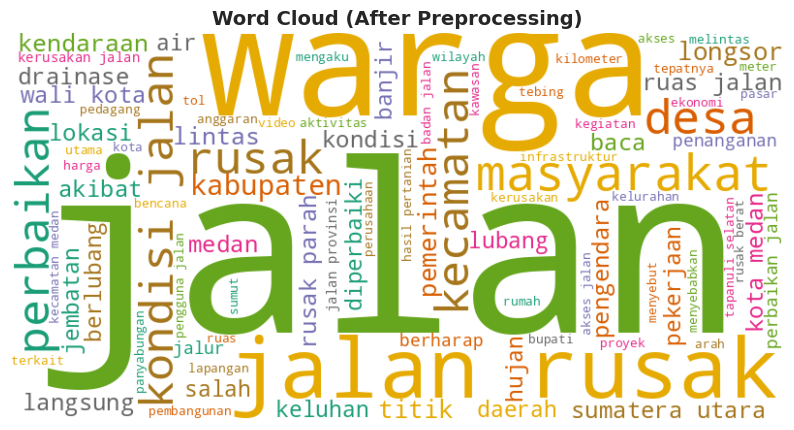

In [ ]:
# import library
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords

# download stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(nltk_stopwords.words('indonesian'))

custom_stopwords = [
    'yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo', 'kalo', 'amp', 'biar',
    'bikin', 'bilang', 'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
    'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 'jd', 'jgn', 'sdh',
    'aja', 'n', 't', 'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
    'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'pada',
    'adalah', 'saya', 'aku', 'kami', 'kita', 'mereka'
]
stop_words.update(custom_stopwords)

# preprocessing data
df_vis['Teks_Bersih'] = df_vis['Teks'].apply(lambda x: clean_text(x))

# generate wordcloud
all_text_clean = ' '.join(df_vis['Teks_Bersih'].astype(str).tolist())

wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    min_font_size=10,
    max_words=200,
    colormap='Dark2',
    regexp=r"\w{3,}"
).generate(all_text_clean)

# show
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud (After Preprocessing)', fontsize=14, fontweight='bold')
plt.show()

# **Ekstraksi Fitur dan SMOTE**

In [ ]:
# load data
X_raw = df['Teks'].astype(str)
y_raw = df['Label']

# TF-IDF (ubah teks menjadi angka)
print("lagi mengubah teks jadi angka...")
tfidf = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf.fit_transform(X_raw)

# split data sebelum SMOTE
# pisah data ujian (test) yang murni
print("\nlagi membagi data latih dan uji...")
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

print(f"jumlah data latih asli: {X_train.shape[0]}")
print(f"jumlah data uji murni : {X_test.shape[0]}")

# penerapan SMOTE pada data latih
print("\nlagi menyeimbangkan data latih pake smote...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("distribusi data latih setelah smote:")
print(y_train_resampled.value_counts())

lagi mengubah teks jadi angka...

lagi membagi data latih dan uji...
jumlah data latih asli: 687
jumlah data uji murni : 172

lagi menyeimbangkan data latih pake smote...
distribusi data latih setelah smote:
Label
Positif    433
Negatif    433
Netral     433
Name: count, dtype: int64


# **Visualisasi Hasil SMOTE**



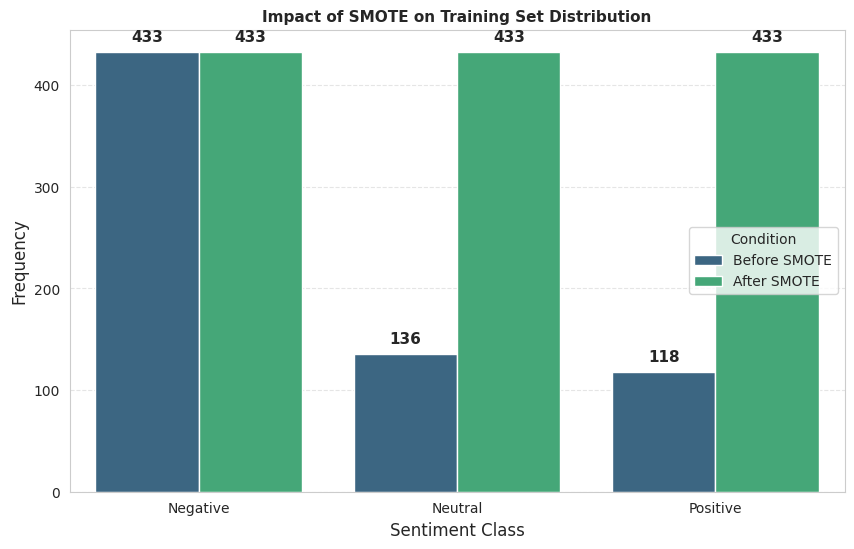

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# set data untuk plot
try:
    counts_before = y_train.value_counts().sort_index()
    counts_after = pd.Series(y_train_resampled).value_counts().sort_index()

    df_visual = pd.DataFrame({
        'Sentiment': counts_before.index.tolist() + counts_after.index.tolist(),
        'Count': counts_before.values.tolist() + counts_after.values.tolist(),
        'Condition': ['Before SMOTE'] * len(counts_before) + ['After SMOTE'] * len(counts_after)
    })

    map_sentimen = {0: 'Negative', 1: 'Neutral', 2: 'Positive',
                    'Negatif': 'Negative', 'Netral': 'Neutral', 'Positif': 'Positive'}

    df_visual['Sentiment'] = df_visual['Sentiment'].replace(map_sentimen)

    # plotting
    plt.figure(figsize=(10, 6))

    ax = sns.barplot(data=df_visual, x='Sentiment', y='Count', hue='Condition', palette='viridis')

    for p in ax.patches:
        if p.get_height() > 0:
            height = int(p.get_height())
            ax.annotate(f'{height}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        xytext=(0, 5), textcoords='offset points',
                        fontsize=11, fontweight='bold')

    plt.title('Impact of SMOTE on Training Set Distribution', fontsize=11, fontweight='bold')
    plt.xlabel('Sentiment Class', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(title='Condition')

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

except NameError:
    print("⚠️ Variables not found (ensure y_train and y_train_resampled are defined)")

# **Hasil Akurasi Model dan Confusion Matrix (Evaluasi)**

Training the model...
Model training completed!

--- Model Evaluation Results (Test Data) ---
Accuracy: 70.93%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.74      0.80       108
     Neutral       0.58      0.62      0.60        34
    Positive       0.49      0.70      0.58        30

    accuracy                           0.71       172
   macro avg       0.64      0.69      0.66       172
weighted avg       0.74      0.71      0.72       172



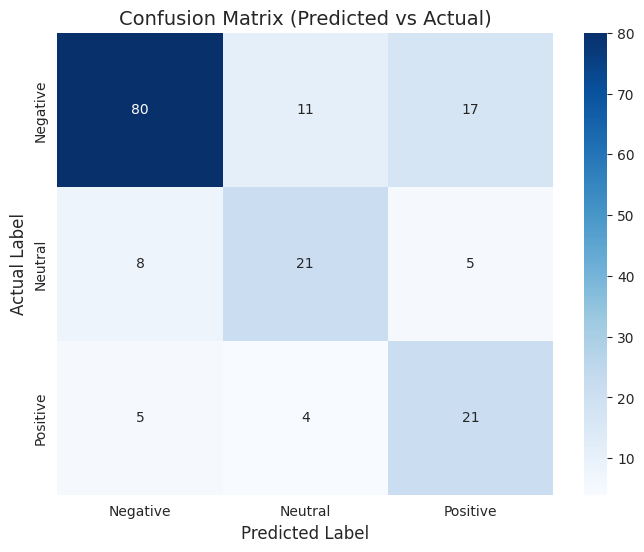

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# training model
print("Training the model...")
model_nb = MultinomialNB()
model_nb.fit(X_train_resampled, y_train_resampled)
print("Model training completed!")

# prediksi
y_pred = model_nb.predict(X_test)

# evaluasi model
print("\n--- Model Evaluation Results (Test Data) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

print("\nClassification Report:")
target_labels = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_labels))

# visualisasi confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_labels,
            yticklabels=target_labels)

plt.title('Confusion Matrix (Predicted vs Actual)', fontsize=14)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# **Hasil Prediksi Data Uji**


--- Prediction Summary (Test Data) ---
          Count Percentage (%)
Negative     93          54.1%
Neutral      36          20.9%
Positive     43          25.0%
Total Test Data: 172


/tmp/ipython-input-3290032007.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=jumlah_per_label.values, palette=colors)


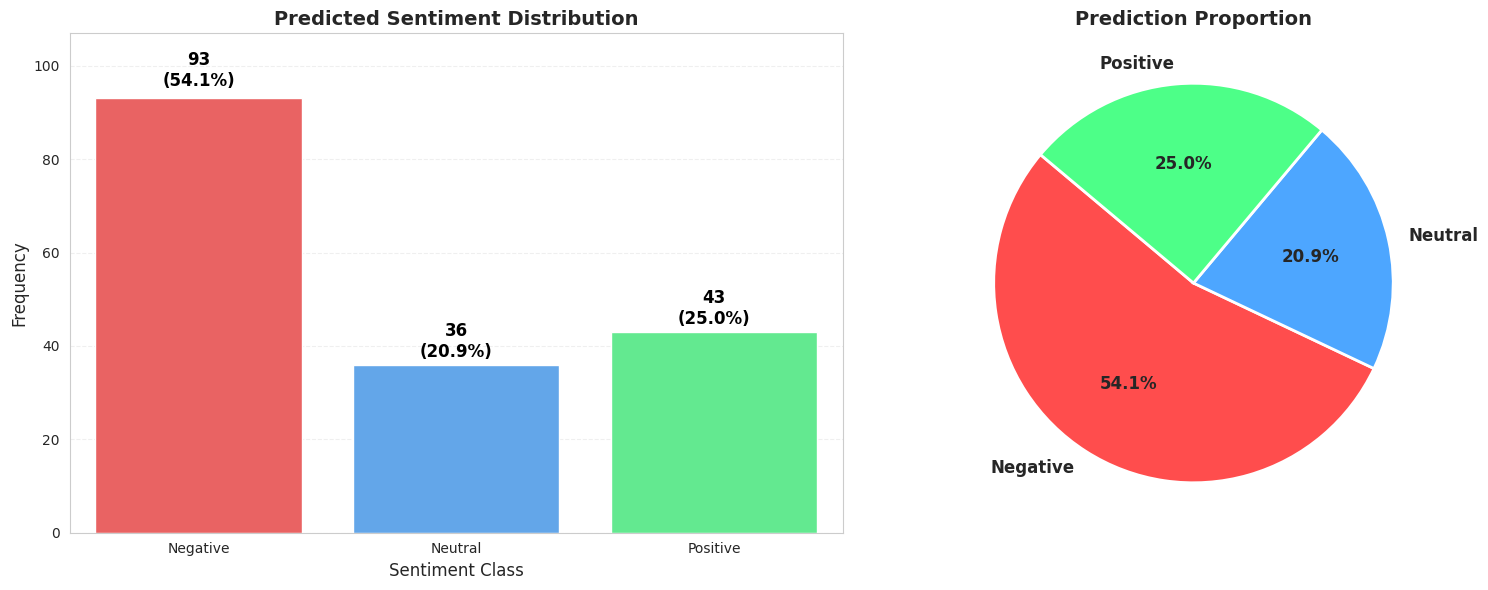

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# siapkan data
data_prediksi = pd.Series(y_pred)
jumlah_per_label = data_prediksi.value_counts().sort_index()

label_map = {
    0: 'Negative', 1: 'Neutral', 2: 'Positive',
    'Negatif': 'Negative', 'Netral': 'Neutral', 'Positif': 'Positive'
}

jumlah_per_label.index = jumlah_per_label.index.map(lambda x: label_map.get(x, x))

total_data = len(data_prediksi)
persentase = (jumlah_per_label / total_data) * 100

# print ringkasan teks
df_summary = pd.DataFrame({
    'Count': jumlah_per_label,
    'Percentage (%)': persentase.map('{:.1f}%'.format)
})

print("\n--- Prediction Summary (Test Data) ---")
print(df_summary)
print(f"Total Test Data: {total_data}")

# visualisasi
plt.figure(figsize=(16, 6))

# grafik bar chart
plt.subplot(1, 2, 1)
urutan_warna = ['#ff4d4d', '#4da6ff', '#4dff88']
labels = jumlah_per_label.index.tolist()

colors = urutan_warna[:len(labels)]

ax = sns.barplot(x=labels, y=jumlah_per_label.values, palette=colors)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    pct_val = persentase.iloc[i]
    label_text = f"{int(height)}\n({pct_val:.1f}%)"

    ax.text(p.get_x() + p.get_width() / 2., height + (height*0.02),
            label_text,
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title('Predicted Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.ylim(0, max(jumlah_per_label.values) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# grafik pie chart
plt.subplot(1, 2, 2)
plt.pie(jumlah_per_label, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
        wedgeprops={'edgecolor': 'white', 'linewidth': 2})

plt.title('Prediction Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()